In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip dev_phase.zip

Archive:  dev_phase.zip
   creating: subtask1/
   creating: subtask1/dev/
  inflating: subtask1/dev/nep.csv    
  inflating: subtask1/dev/ita.csv    
  inflating: subtask1/dev/pol.csv    
  inflating: subtask1/dev/rus.csv    
  inflating: subtask1/dev/tel.csv    
  inflating: subtask1/dev/hin.csv    
  inflating: subtask1/dev/hau.csv    
  inflating: subtask1/dev/pan.csv    
  inflating: subtask1/dev/ori.csv    
  inflating: subtask1/dev/spa.csv    
  inflating: subtask1/dev/deu.csv    
  inflating: subtask1/dev/fas.csv    
  inflating: subtask1/dev/arb.csv    
  inflating: subtask1/dev/ben.csv    
  inflating: subtask1/dev/amh.csv    
  inflating: subtask1/dev/khm.csv    
  inflating: subtask1/dev/tur.csv    
  inflating: subtask1/dev/zho.csv    
  inflating: subtask1/dev/eng.csv    
  inflating: subtask1/dev/swa.csv    
  inflating: subtask1/dev/urd.csv    
  inflating: subtask1/dev/mya.csv    
   creating: subtask1/train/
  inflating: subtask1/train/nep.csv  
  inflating: subtask1/t

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/nlp/

/content/drive/.shortcut-targets-by-id/1hHGaf-koA0V3FjQP2dvs7HFCaVW94hPv/nlp


In [ ]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np

import torch



from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback
)
from torch.utils.data import Dataset
import matplotlib.pyplot as plt


In [ ]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [ ]:
# Load the training and validation data for subtask 1

train = pd.read_csv('subtask1/train/swa.csv')
# train = pd.read_csv('amh.csv')
# val = pd.read_csv('subtask1/train/eng.csv')

test = pd.read_csv('subtask1/dev/swa.csv')
# test = pd.read_csv('amh (1).csv')

#split train data into traina and val
train, val = train_test_split(
    train,
    test_size=0.2,        # 20% for validation
    stratify=train['polarization']      # Ensures you get the same split every time
)

train.head()

#models to try https://huggingface.co/google-bert/bert-large-uncased-whole-word-masking
# https://huggingface.co/google-bert/bert-base-multilingual-cased
# https://huggingface.co/BAAI/bge-reranker-v2-m3
#https://huggingface.co/Oloruntobi/bert-hausa-sentimental
#afroxlmr-large

,id,text,polarization
988,swa_d40fa8250e2295a553f48553efedb370,viongozi wa zamani walikuwa wana utu uadilifu ...,1
5628,swa_5802cf8de49547e6201d9e9d53b8fd94,hakuna shit wewe mjinga bubu punda sasa nenda ...,0
217,swa_a93a8badd8b05ca31a9063978800cabc,hawa wahindi wafala wanafollow kwa wingi ili w...,1
5326,swa_9522b574b98e56a344dc743a1f032f83,ameezysangels mimi ni takataka ya kutombwa,0
2936,swa_a93e6529c3cf62918cdec0268ba9d93e,jamani justdome amp muziki wake wa nigger unaa...,0


In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}
    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

class PolarizationTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item

# Then create your test dataset without labels:


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('pranaydeeps/SwahBERT-base-cased')#bert-base-uncased cardiffnlp/twitter-roberta-base-sentiment-latest

# Create datasets
train_dataset = PolarizationDataset(train['text'].tolist(), train['polarization'].tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val['polarization'].tolist(), tokenizer)
test_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Models

- Davlan/afro-xlmr-base for swhaili
- xlr-roberta for amharic
- cardiffnlp/twitter-roberta-base-sentiment-latest for english

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('pranaydeeps/SwahBERT-base-cased', num_labels=2)#, num_labels=2,    ignore_mismatched_sizes=True

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pranaydeeps/SwahBERT-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
# training_args = TrainingArguments(
#         output_dir=f"/content/outputs/",
#         num_train_epochs=5,
#         learning_rate=2e-5,
#         per_device_train_batch_size=64,
#         per_device_eval_batch_size=8,
#         eval_strategy="epoch",
#         save_strategy="no",
#         logging_steps=1000,
#         disable_tqdm=False,
#         metric_for_best_model="f1_macro",
#         load_best_model_at_end=False,
#         greater_is_better=True,
#         save_total_limit=1
#     )

training_args = TrainingArguments(
    output_dir="/content/outputs/",
    num_train_epochs=5,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",

    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,

    # Evaluate once per epoch
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,

    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Log every 2000 steps instead of 100
    logging_strategy="epoch",
    logging_steps=1000,  # Much less frequent
    logging_first_step=False,  # Don't log first step

    weight_decay=0.01,
    max_grad_norm=1.0,
    fp16=True,
    dataloader_num_workers=2,
    seed=40,
    disable_tqdm=False,
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    data_collator=DataCollatorWithPadding(tokenizer) # Data collator for dynamic padding
)

# Train the model
trainer.train()

log_history = trainer.state.log_history
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.012800,1.480324,0.747545
2,0.104300,0.997598,0.735218
3,0.046100,1.095373,0.764097
4,0.033000,1.215942,0.764064
5,0.033200,1.195711,0.766254


Macro F1 score on validation set: 0.7662539720009381


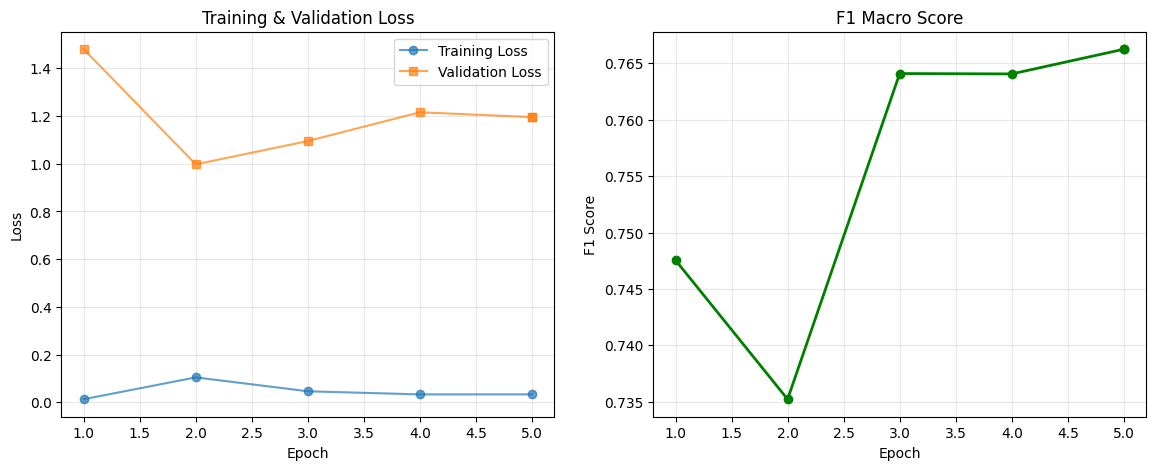

In [ ]:



# Convert to DataFrame for easier plotting
logs_df = pd.DataFrame(log_history)
# print(logs_df)

# Prepare data
train_logs = logs_df[logs_df['loss'].notna()]
eval_logs = logs_df[logs_df['eval_loss'].notna()]

# Create subplot mosaic
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Both losses
axes[0].plot(train_logs['epoch'], train_logs['loss'], label='Training Loss', marker='o', alpha=0.7)
axes[0].plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss', marker='s', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: F1 Score
axes[1].plot(eval_logs['epoch'], eval_logs['eval_f1_macro'], marker='o', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Macro Score')
axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
plt.savefig('single_train_swa',dpi=200,format='pdf' )
plt.show()

In [ ]:
import os
import zipfile

predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = predictions.predictions.argmax(-1)

# Create a new dataframe with only id and predicted polarization
results_df = pd.DataFrame({
    'id': test['id'],
    'polarization': predicted_labels
})

# Create the folder if it doesn't exist
os.makedirs('subtask_1', exist_ok=True)

# Save to CSV in the folder
csv_path = 'subtask_1/pred_swa.csv'
results_df.to_csv(csv_path, index=False)

print(f"Saved predictions to {csv_path}")
print(results_df.head())

# Compress the folder
zip_filename = 'subtask_1_swa_sing.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the folder and add all files
    for root, dirs, files in os.walk('subtask_1'):
        for file in files:
            file_path = os.path.join(root, file)
            # Add file to zip with relative path
            arcname = os.path.join(os.path.basename(root), file)
            zipf.write(file_path, arcname)

print(f"Created compressed file: {zip_filename}")

Saved predictions to subtask_1/pred_swa.csv
                                     id  polarization
0  swa_a5748df181277341143f7da4175add4a             1
1  swa_2df0d42f9b49ea2e4fb006b2e6604e6d             1
2  swa_3718757514005767302b7220b08e409d             1
3  swa_9fa3337a35cce723d60c06056d422330             1
4  swa_5c39ac8ef70345e9e3c21a47f8769bc0             1
Created compressed file: subtask_1_swa_sing.zip


In [ ]:
#prediction on test
trainer.save_model('swa_model_single')

## look for loading model

In [ ]:
#loading pretrained model
model = AutoModelForSequenceClassification.from_pretrained('swa_model')

# Load the tokenizer (if you saved it)
tokenizer = AutoTokenizer.from_pretrained('swa_model')

# Task 1 ensemble

In [ ]:
#config


# nlptown/bert-base-multilingual-uncased-sentiment
# ManavDhayeCoder/sentiment-bert
# tabularisai/multilingual-sentiment-analysis
# cardiffnlp/twitter-xlm-roberta-base-sentiment
# cardiffnlp/twitter-roberta-base-hate-multiclass-latest
# FacebookAI/xlm-roberta-base
# Tadesse/AfroXLMR-Social
# Davlan/afro-xlmr-base
CONFIG = {
    'english': {#cardiffnlp/twitter-roberta-base-sentiment-latest
        'model_name': 'cardiffnlp/twitter-xlm-roberta-base-sentiment',
        'train_file': 'subtask1/train/eng.csv',
        'test_file': 'subtask1/dev/eng.csv',
        'output_name': 'eng'
    },
    'swahili': {
        'model_name': 'Tadesse/AfroXLMR-Social',
        'train_file': 'subtask1/train/swa.csv',
        'test_file': 'subtask1/dev/swa.csv',
        'output_name': 'swa'
    }
}
# Select language
LANGUAGE = 'swahili'  # Change to 'english', 'swahili', or 'amharic'
config = CONFIG[LANGUAGE]

In [ ]:
# @title large ensemble singlelabel
import os
import zipfile
import json



# # Select language
# LANGUAGE = 'english'  # Change to 'english', 'swahili', or 'amharic'
# config = CONFIG[LANGUAGE]

# ============================================
# Dataset Classes
# ============================================
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

class PolarizationTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item

# ============================================
# Custom Trainer with Combined Metric
# ============================================
class CombinedMetricTrainer(Trainer):
    """
    Custom Trainer that optimizes for both F1 score and loss reduction
    """
    def __init__(self, *args, f1_weight=0.7, loss_weight=0.3, **kwargs):
        super().__init__(*args, **kwargs)
        self.f1_weight = f1_weight
        self.loss_weight = loss_weight
        self.train_losses = []

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):  # ← ADDED num_items_in_batch
        """Track training loss"""
        outputs = model(**inputs)
        loss = outputs.loss

        # Store training loss for monitoring
        self.train_losses.append(loss.item())

        return (loss, outputs) if return_outputs else loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """Add combined score metric"""
        metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)

        # Get F1 and loss
        f1 = metrics.get(f'{metric_key_prefix}_f1_macro', 0)
        loss = metrics.get(f'{metric_key_prefix}_loss', 0)

        # Calculate combined score
        # Higher F1 is better, lower loss is better
        # Normalize loss (typically 0-2 range) to be comparable with F1 (0-1 range)
        normalized_loss = min(loss / 2.0, 1.0)  # Cap at 1.0

        # Combined score: maximize F1, minimize loss
        combined_score = (self.f1_weight * f1) - (self.loss_weight * normalized_loss)

        metrics[f'{metric_key_prefix}_combined_score'] = combined_score

        # Calculate average training loss for this epoch
        if self.train_losses:
            avg_train_loss = np.mean(self.train_losses[-100:])  # Last 100 steps
            metrics[f'{metric_key_prefix}_train_loss_recent'] = avg_train_loss

        return metrics

# ============================================
# Enhanced Monitoring Callback
# ============================================
class EnhancedMonitoringCallback(TrainerCallback):
    """
    Callback to monitor and log F1, train loss, and eval loss
    """
    def __init__(self):
        self.best_f1 = -float('inf')
        self.best_eval_loss = float('inf')
        self.best_train_loss = float('inf')
        self.best_combined = -float('inf')
        self.history = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_f1': [],
            'combined_score': []
        }

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Log training metrics"""
        if logs and 'loss' in logs:
            if logs['loss'] < self.best_train_loss:
                self.best_train_loss = logs['loss']

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """Track evaluation metrics"""
        if metrics is not None:
            epoch = state.epoch
            train_loss = metrics.get('train_loss', state.log_history[-1].get('loss', 0))
            eval_loss = metrics.get('eval_loss', 0)
            eval_f1 = metrics.get('eval_f1_macro', 0)
            combined_score = metrics.get('eval_combined_score', 0)

            # Store history
            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['eval_loss'].append(eval_loss)
            self.history['eval_f1'].append(eval_f1)
            self.history['combined_score'].append(combined_score)

            # Update best metrics
            if eval_f1 > self.best_f1:
                self.best_f1 = eval_f1
            if eval_loss < self.best_eval_loss:
                self.best_eval_loss = eval_loss
            if combined_score > self.best_combined:
                self.best_combined = combined_score

            # Print detailed metrics
            print(f"\n{'='*70}")
            print(f"Epoch {epoch:.1f} Metrics:")
            print(f"{'='*70}")
            print(f"  F1 Score:        {eval_f1:.4f} (Best: {self.best_f1:.4f})")
            print(f"  Eval Loss:       {eval_loss:.4f} (Best: {self.best_eval_loss:.4f})")
            print(f"  Train Loss:      {train_loss:.4f} (Best: {self.best_train_loss:.4f})")
            print(f"  Combined Score:  {combined_score:.4f} (Best: {self.best_combined:.4f})")

            # Performance indicators
            if eval_f1 == self.best_f1:
                print(f"  ✓ NEW BEST F1!")
            if eval_loss == self.best_eval_loss:
                print(f"  ✓ NEW BEST EVAL LOSS!")
            if combined_score == self.best_combined:
                print(f"  ✓ NEW BEST COMBINED SCORE!")
            print(f"{'='*70}\n")

# ============================================
# Early Stopping with Combined Metric
# ============================================
class CombinedEarlyStoppingCallback(TrainerCallback):
    """
    Early stopping based on combined F1 and loss metric
    """
    def __init__(self, patience=5):
        self.patience = patience
        self.best_combined_score = -float('inf')
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            combined_score = metrics.get('eval_combined_score', -float('inf'))

            if combined_score > self.best_combined_score:
                self.best_combined_score = combined_score
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.patience:
                print(f"\n⚠ Early stopping triggered after {self.patience} epochs without improvement")
                print(f"Best combined score: {self.best_combined_score:.4f}")
                control.should_training_stop = True

# ============================================
# K-Fold Cross-Validation with Enhanced Training
# ============================================
def train_kfold_cv(train_df, model_name, n_splits=5, seed=42):
    """
    Train model using K-Fold Cross-Validation with focus on F1 and loss reduction
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    fold_models = []
    fold_scores = []
    fold_metrics = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    print(f"\n{'='*70}")
    print(f"Starting {n_splits}-Fold Cross-Validation")
    print(f"Model: {model_name}")
    print(f"Total samples: {len(train_df)}")
    print(f"Optimization: Maximize F1 + Minimize Loss")
    print(f"{'='*70}\n")

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['polarization'])):
        print(f"\n{'='*70}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*70}")

        # Split data
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        print(f"Train size: {len(train_fold)}, Val size: {len(val_fold)}")

        # Create datasets
        train_dataset = PolarizationDataset(
            train_fold['text'].tolist(),
            train_fold['polarization'].tolist(),
            tokenizer
        )
        val_dataset = PolarizationDataset(
            val_fold['text'].tolist(),
            val_fold['polarization'].tolist(),
            tokenizer
        )

        # Initialize model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,ignore_mismatched_sizes=True
        )

        # Enhanced training arguments
        training_args = TrainingArguments(
            output_dir=f"/content/outputs/fold_{fold+1}",
            num_train_epochs=5,

            # Learning rate optimization
            learning_rate=2e-5,
            lr_scheduler_type="cosine",
            warmup_ratio=0.15,  # Increased warmup for stability

            # Batch size and gradient accumulation
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            gradient_accumulation_steps=2,

            # Regularization for loss reduction
            weight_decay=0.01,
            max_grad_norm=1.0,
            label_smoothing_factor=0.1,  # Helps with loss reduction

            # Evaluation and saving
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=25,
            save_total_limit=2,

            # Model selection based on combined metric
            load_best_model_at_end=True,
            metric_for_best_model="combined_score",
            greater_is_better=True,

            # Performance
            fp16=True,
            dataloader_num_workers=2,

            disable_tqdm=False,
            report_to="none"
        )

        # Compute metrics
        def compute_metrics(p):
            preds = np.argmax(p.predictions, axis=1)
            f1 = f1_score(p.label_ids, preds, average='macro')
            return {'f1_macro': f1}

        # Initialize callbacks
        monitoring_callback = EnhancedMonitoringCallback()
        early_stopping_callback = CombinedEarlyStoppingCallback(patience=5)

        # Initialize custom trainer
        trainer = CombinedMetricTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer),
            callbacks=[monitoring_callback, early_stopping_callback],
            f1_weight=0.7,  # 70% weight on F1
            loss_weight=0.3  # 30% weight on loss
        )

        # Train
        print(f"\nTraining Fold {fold + 1}...")
        trainer.train()



        # Final evaluation
        eval_results = trainer.evaluate()
        fold_score = eval_results['eval_f1_macro']
        fold_eval_loss = eval_results['eval_loss']
        fold_combined = eval_results['eval_combined_score']

        fold_scores.append(fold_score)
        fold_metrics.append({
            'fold': fold + 1,
            'f1': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_combined,
            'best_f1': monitoring_callback.best_f1,
            'best_eval_loss': monitoring_callback.best_eval_loss,
            'best_train_loss': monitoring_callback.best_train_loss
        })

        print(f"\n{'='*70}")
        print(f"Fold {fold + 1} Final Results:")
        print(f"{'='*70}")
        print(f"  F1 Score:       {fold_score:.4f}")
        print(f"  Eval Loss:      {fold_eval_loss:.4f}")
        print(f"  Combined Score: {fold_combined:.4f}")
        print(f"  Best F1:        {monitoring_callback.best_f1:.4f}")
        print(f"  Best Eval Loss: {monitoring_callback.best_eval_loss:.4f}")
        print(f"  Best Train Loss:{monitoring_callback.best_train_loss:.4f}")
        print(f"{'='*70}")

        # Save model info
        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'score': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_combined,
            'fold': fold + 1,
            'history': monitoring_callback.history
        })
    #plot results
    plot_all_folds(fold_models)

    # Print comprehensive summary
    print(f"\n{'='*70}")
    print(f"CROSS-VALIDATION SUMMARY")
    print(f"{'='*70}")
    print(f"\nPer-Fold Results:")
    print(f"{'Fold':<8} {'F1 Score':<12} {'Eval Loss':<12} {'Combined':<12}")
    print(f"{'-'*50}")
    for metrics in fold_metrics:
        print(f"{metrics['fold']:<8} {metrics['f1']:<12.4f} {metrics['eval_loss']:<12.4f} {metrics['combined_score']:<12.4f}")

    print(f"\nAggregate Statistics:")
    print(f"  Mean F1:       {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    print(f"  Mean Eval Loss:{np.mean([m['eval_loss'] for m in fold_metrics]):.4f} ± {np.std([m['eval_loss'] for m in fold_metrics]):.4f}")
    print(f"  Mean Combined: {np.mean([m['combined_score'] for m in fold_metrics]):.4f} ± {np.std([m['combined_score'] for m in fold_metrics]):.4f}")
    print(f"\n  Best Fold:     {np.argmax(fold_scores) + 1} (F1 = {max(fold_scores):.4f})")
    print(f"  Lowest Loss:   {np.argmin([m['eval_loss'] for m in fold_metrics]) + 1} (Loss = {min([m['eval_loss'] for m in fold_metrics]):.4f})")
    print(f"{'='*70}\n")

    return fold_models, fold_metrics

# ============================================
# Ensemble Prediction
# ============================================
def ensemble_predict(fold_models, test_dataset, method='weighted'):
    """
    Make predictions using ensemble with optional weighting by performance

    Args:
        method: 'average', 'weighted' (by F1), or 'weighted_combined' (by combined score)
    """
    all_predictions = []
    weights = []

    for i, fold_model in enumerate(fold_models):
        print(f"Getting predictions from Fold {i+1} (F1: {fold_model['score']:.4f}, Loss: {fold_model['eval_loss']:.4f})...")

        model = fold_model['model']
        tokenizer = fold_model['tokenizer']

        trainer = Trainer(
            model=model,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        predictions = trainer.predict(test_dataset)
        probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)
        all_predictions.append(probs.numpy())

        # Calculate weight based on method
        if method == 'weighted':
            weights.append(fold_model['score'])  # Weight by F1
        elif method == 'weighted_combined':
            weights.append(fold_model['combined_score'])  # Weight by combined score
        else:
            weights.append(1.0)  # Equal weights

    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()

    print(f"\nEnsemble weights: {weights}")

    # Weighted average of probabilities
    weighted_probs = np.zeros_like(all_predictions[0])
    for pred, weight in zip(all_predictions, weights):
        weighted_probs += pred * weight

    final_predictions = np.argmax(weighted_probs, axis=1)

    return final_predictions

# ============================================
# LOAD SAVED MODEL FOR PREDICTION
# ============================================
def load_saved_model(language='english'):
    """
    Load a previously saved model

    Args:
        language: 'english', 'swahili', or 'amharic'

    Returns:
        model, tokenizer
    """
    config = CONFIG[language]
    model_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/best_model_{config['output_name']}"

    print(f"Loading model from: {model_path}")

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    print(f"✓ Model loaded successfully!")

    return model, tokenizer

# ============================================
# PREDICT WITH SAVED MODEL
# ============================================
def predict_with_saved_model(test_csv_path, language='english', output_csv='predictions.csv'):
    """
    Make predictions using a saved model

    Args:
        test_csv_path: Path to test CSV file
        language: 'english', 'swahili', or 'amharic'
        output_csv: Output CSV filename
    """
    # Load saved model
    model, tokenizer = load_saved_model(language)

    # Load test data
    test = pd.read_csv(test_csv_path)
    print(f"Test size: {len(test)}")

    # Create test dataset
    test_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

    # Create trainer for prediction
    trainer = Trainer(
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Make predictions
    print("Making predictions...")
    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(-1)

    # Save results
    results_df = pd.DataFrame({
        'id': test['id'],
        'polarization': predicted_labels
    })

    results_df.to_csv(output_csv, index=False)

    print(f"✓ Predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head())
    print(f"\nPrediction distribution:")
    print(results_df['polarization'].value_counts())

    return results_df

# ============================================
# CONTINUE TRAINING SAVED MODEL
# ============================================
def continue_training(train_csv_path, language='english', additional_epochs=5):
    """
    Continue training a saved model

    Args:
        train_csv_path: Path to training CSV
        language: 'english', 'swahili', or 'amharic'
        additional_epochs: Number of additional epochs to train
    """
    from sklearn.model_selection import train_test_split

    # Load saved model
    model, tokenizer = load_saved_model(language)

    # Load training data
    train = pd.read_csv(train_csv_path)
    print(f"Train size: {len(train)}")

    # Split into train/val
    train_split, val_split = train_test_split(
        train,
        test_size=0.2,
        stratify=train['polarization'],
        random_state=42
    )

    # Create datasets
    train_dataset = PolarizationDataset(
        train_split['text'].tolist(),
        train_split['polarization'].tolist(),
        tokenizer
    )
    val_dataset = PolarizationDataset(
        val_split['text'].tolist(),
        val_split['polarization'].tolist(),
        tokenizer
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"/content/outputs/continued_training",
        num_train_epochs=additional_epochs,
        learning_rate=1e-5,  # Lower learning rate for fine-tuning
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=2,
        warmup_ratio=0.1,
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=25,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        dataloader_num_workers=2,
    )

    # Compute metrics
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Continue training
    print(f"\nContinuing training for {additional_epochs} epochs...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\n✓ Final F1 Score: {eval_results['eval_f1_macro']:.4f}")

    # Save updated model
    config = CONFIG[language]
    updated_model_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/best_model_{config['output_name']}_updated"
    trainer.save_model(updated_model_path)
    tokenizer.save_pretrained(updated_model_path)

    print(f"✓ Updated model saved to: {updated_model_path}")

    return trainer

def plot_all_folds(fold_models):
    """Plot training history for all folds with complementary colors"""
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    # Create color palette - using tab10 colormap for distinct, complementary colors
    n_folds = len(fold_models)
    colors = plt.cm.tab10(np.linspace(0, 0.9, n_folds))

    # Create subplot mosaic
    fig = plt.figure(figsize=(16, 6))
    mosaic = [['losses', 'f1']]
    axes = fig.subplot_mosaic(mosaic)

    # Left plot: Losses for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        # Plot train loss (dashed) and eval loss (solid) with same color
        axes['losses'].plot(history['epoch'], history['train_loss'],
                           label=f'Fold {fold_num} Train',
                           alpha=0.7,
                           linestyle='--',
                           color=color,
                           linewidth=2)
        axes['losses'].plot(history['epoch'], history['eval_loss'],
                           label=f'Fold {fold_num} Val',
                           alpha=0.9,
                           color=color,
                           linewidth=2)

    axes['losses'].set_xlabel('Epoch', fontsize=11)
    axes['losses'].set_ylabel('Loss', fontsize=11)
    axes['losses'].set_title('Training & Validation Loss - All Folds', fontsize=12, fontweight='bold')
    axes['losses'].legend( fontsize=9, framealpha=0.9)
    axes['losses'].grid(True, alpha=0.3, linestyle='--')

    # Right plot: F1 scores for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['f1'].plot(history['epoch'], history['eval_f1'],
                       label=f'Fold {fold_num}',
                       marker='o',
                       alpha=0.85,
                       color=color,
                       linewidth=2,
                       markersize=6)

    axes['f1'].set_xlabel('Epoch', fontsize=11)
    axes['f1'].set_ylabel('F1 Score', fontsize=11)
    axes['f1'].set_title('F1 Macro Score - All Folds', fontsize=12, fontweight='bold')
    axes['f1'].legend( fontsize=9, framealpha=0.9)
    axes['f1'].grid(True, alpha=0.3, linestyle='--')
    plt.savefig('ensem_task1_swa_afrosocial.pdf',dpi=200,format='pdf')

    # plt.tight_layout()
    plt.show()

# Use it in your main function:
# After training completes, add:



# ============================================
# ENSEMBLE PREDICT WITH SAVED MODELS
# ============================================
def ensemble_predict_with_saved_models(test_csv_path, language='english',
                                       n_folds=5, method='average',
                                       output_csv='ensemble_predictions.csv'):
    """
    Make ensemble predictions using all saved fold models

    Args:
        test_csv_path: Path to test CSV file
        language: 'english', 'swahili', or 'amharic'
        n_folds: Number of folds to load
        method: 'average', 'weighted', or 'weighted_combined'
        output_csv: Output CSV filename
    """
    # Load all fold models
    fold_models = load_all_fold_models(language, n_folds)

    # Load test data
    test = pd.read_csv(test_csv_path)
    print(f"\nTest size: {len(test)}")

    # Create test dataset (use tokenizer from first fold)
    tokenizer = fold_models[0]['tokenizer']
    test_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

    # Make ensemble predictions
    print(f"\nMaking ensemble predictions with method: {method}")
    final_predictions = ensemble_predict(fold_models, test_dataset, method=method)

    # Save results
    results_df = pd.DataFrame({
        'id': test['id'],
        'polarization': final_predictions
    })

    results_df.to_csv(output_csv, index=False)

    print(f"\n✓ Ensemble predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df['polarization'].value_counts())

    return results_df

# ============================================
# SAVE FOLD METRICS
# ============================================
def save_fold_metrics(fold_metrics, language='english'):
    """Save fold metrics to JSON file"""
    config = CONFIG[language]
    metrics_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/fold_metrics_{config['output_name']}.json"

    with open(metrics_path, 'w') as f:
        json.dump(fold_metrics, f, indent=2)

    print(f"✓ Fold metrics saved to: {metrics_path}")

# ============================================
# LOAD ALL FOLD MODELS FOR ENSEMBLE (IMPROVED)
# ============================================
def load_all_fold_models(language='english', n_folds=5):
    """
    Load all saved fold models for ensemble prediction

    Args:
        language: 'english', 'swahili', or 'amharic'
        n_folds: Number of folds to load

    Returns:
        fold_models: List of model dictionaries
    """
    config = CONFIG[language]
    fold_models = []

    # Try to load saved metrics
    metrics_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/fold_metrics_{config['output_name']}.json"
    fold_metrics = None

    try:
        with open(metrics_path, 'r') as f:
            fold_metrics = json.load(f)
        print(f"✓ Loaded fold metrics from: {metrics_path}")
    except FileNotFoundError:
        print(f"⚠ No saved metrics found at {metrics_path}")
        print(f"  Using equal weights for ensemble")

    print(f"\nLoading all {n_folds} fold models for {language}...")

    for fold_num in range(1, n_folds + 1):
        fold_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/model_{config['output_name']}_fold_{fold_num}"

        print(f"  Loading Fold {fold_num} from: {fold_path}")

        # Load model and tokenizer
        model = AutoModelForSequenceClassification.from_pretrained(fold_path)
        tokenizer = AutoTokenizer.from_pretrained(fold_path)

        # Get metrics for this fold if available
        if fold_metrics:
            fold_metric = fold_metrics[fold_num - 1]  # 0-indexed
            score = fold_metric['f1']
            eval_loss = fold_metric['eval_loss']
            combined_score = fold_metric['combined_score']
        else:
            # Default values if no metrics file
            score = 1.0
            eval_loss = 1.0
            combined_score = 1.0

        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'fold': fold_num,
            'score': score,
            'eval_loss': eval_loss,
            'combined_score': combined_score
        })

        print(f"  ✓ Fold {fold_num} loaded (F1: {score:.4f}, Loss: {eval_loss:.4f})")

    print(f"\n✓ All {n_folds} models loaded successfully!")

    return fold_models
# ============================================
# Main Training Pipeline
# ============================================
def main():
    # Load data
    print(f"Loading data for {LANGUAGE}...")
    train = pd.read_csv(config['train_file'])
    test = pd.read_csv(config['test_file'])

    print(f"Train size: {len(train)}")
    print(f"Test size: {len(test)}")
    print(f"Class distribution:\n{train['polarization'].value_counts()}")

    # Train with K-Fold CV
    fold_models, fold_metrics = train_kfold_cv(
        train,
        config['model_name'],
        n_splits=5,
        seed=42
    )


    # ============================================
    # SAVE BEST FOLD MODEL
    # ============================================
    # Find best fold based on combined score
    best_fold_idx = np.argmax([m['combined_score'] for m in fold_metrics])
    best_fold_model = fold_models[best_fold_idx]


    save_fold_metrics(fold_metrics, LANGUAGE)

    # Save the best fold model
    model_save_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/best_model_{config['output_name']}"
    best_fold_model['model'].save_pretrained(model_save_path)
    best_fold_model['tokenizer'].save_pretrained(model_save_path)

    print(f"\n{'='*70}")
    print(f"✓ Best model saved to: {model_save_path}")
    print(f"✓ Best fold: {best_fold_model['fold']}")
    print(f"✓ F1 Score: {best_fold_model['score']:.4f}")
    print(f"✓ Eval Loss: {best_fold_model['eval_loss']:.4f}")
    print(f"✓ Combined Score: {best_fold_model['combined_score']:.4f}")
    print(f"{'='*70}\n")

    # ============================================
    # SAVE ALL FOLD MODELS (OPTIONAL)
    # ============================================
    # Uncomment if you want to save all models for later ensemble
    for fold_model in fold_models:
        fold_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/model_{config['output_name']}_fold_{fold_model['fold']}"
        fold_model['model'].save_pretrained(fold_path)
        fold_model['tokenizer'].save_pretrained(fold_path)
        print(f"✓ Saved Fold {fold_model['fold']} to {fold_path}")
    # Load tokenizer

    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

    # Create test dataset
    test_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

    # Ensemble predictions (weighted by combined score)
    print("\n" + "="*70)
    print("Making Weighted Ensemble Predictions")
    print("="*70 + "\n")

    final_predictions = ensemble_predict(
        fold_models,
        test_dataset,
        method='weighted_combined'  # Weight by combined F1+loss score
    )

    # Save predictions
    results_df = pd.DataFrame({
        'id': test['id'],
        'polarization': final_predictions
    })

    os.makedirs('subtask_1', exist_ok=True)
    csv_path = f'subtask_1/pred_{config["output_name"]}.csv'
    results_df.to_csv(csv_path, index=False)

    print(f"\n✓ Saved predictions to {csv_path}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df['polarization'].value_counts())

    # Compress
    zip_filename = f'subtask_1_{config["output_name"]}.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk('subtask_1'):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.join(os.path.basename(root), file)
                zipf.write(file_path, arcname)

    print(f"✓ Created compressed file: {zip_filename}")



In [ ]:
# ============================================
# USAGE EXAMPLES
# ============================================

# Example 1: Train new model (existing main function)
# if __name__ == "__main__":
#     main()

# Example 2: Load saved model and make predictions (single best model)
# if __name__ == "__main__":
#     predictions = predict_with_saved_model(
#         test_csv_path='subtask1/dev/eng.csv',
#         language='english',
#         output_csv='new_predictions.csv'
#     )

# Example 3: Load ALL fold models and make ensemble predictions
# if __name__ == "__main__":
#     predictions = ensemble_predict_with_saved_models(
#         test_csv_path='subtask1/dev/eng.csv',
#         language='english',
#         n_folds=5,
#         method='average',  # or 'weighted' or 'weighted_combined'
#         output_csv='ensemble_predictions.csv'
#     )

# Example 4: Continue training a saved model
# if __name__ == "__main__":
#     trainer = continue_training(
#         train_csv_path='subtask1/train/eng.csv',
#         language='english',
#         additional_epochs=5
#     )

# Example 5: Load model for custom use
# if __name__ == "__main__":
#     model, tokenizer = load_saved_model('english')
#     # Use model and tokenizer for your custom tasks
#     print(f"Model loaded: {model}")
#     print(f"Tokenizer loaded: {tokenizer}")

# Example 6: Load all fold models for custom ensemble
# if __name__ == "__main__":
#     fold_models = load_all_fold_models('english', n_folds=5)
#     # Now you can use fold_models for custom ensemble logic
#     print(f"Loaded {len(fold_models)} models")

# Run main training pipeline
# if __name__ == "__main__":
#     main()

In [ ]:
# Run
if __name__ == "__main__":
    main()

Loading data for swahili...
Train size: 6991
Test size: 349
Class distribution:
polarization
1    3504
0    3487
Name: count, dtype: int64


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]


Starting 5-Fold Cross-Validation
Model: Tadesse/AfroXLMR-Social
Total samples: 6991
Optimization: Maximize F1 + Minimize Loss


FOLD 1/5
Train size: 5592, Val size: 1399


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Tadesse/AfroXLMR-Social and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Fold 1...


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.549100,0.469060,0.770675
2,0.403300,0.430428,0.801223
3,0.308500,0.440708,0.818393
4,0.179000,0.530308,0.822704
5,0.131000,0.557351,0.819155



Epoch 1.0 Metrics:
  F1 Score:        0.7707 (Best: 0.7707)
  Eval Loss:       0.4691 (Best: 0.4691)
  Train Loss:      0.0000 (Best: 0.5491)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 2.0 Metrics:
  F1 Score:        0.8012 (Best: 0.8012)
  Eval Loss:       0.4304 (Best: 0.4304)
  Train Loss:      0.0000 (Best: 0.4033)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST EVAL LOSS!
  ✓ NEW BEST COMBINED SCORE!


Epoch 3.0 Metrics:
  F1 Score:        0.8184 (Best: 0.8184)
  Eval Loss:       0.4407 (Best: 0.4304)
  Train Loss:      0.0000 (Best: 0.3044)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST COMBINED SCORE!


Epoch 4.0 Metrics:
  F1 Score:        0.8227 (Best: 0.8227)
  Eval Loss:       0.5303 (Best: 0.4304)
  Train Loss:      0.0000 (Best: 0.1790)
  Combined Score:  0.0000 (Best: 0.0000)
  ✓ NEW BEST F1!
  ✓ NEW BEST COMBINED SCORE!


Epoch 5.0 Metrics:
  F1 Sco